--- Geometry Check ---
Bob Angles: Theta = 18.43°, Phi = 8.98°
Eve Angles: Theta = -33.69°, Phi = 7.90°

--- Validation Results ---
Power at Bob (Target 1.0): 1.000000
Power at Eve (Target 0.0): 1.144392e-16 (effectively zero)

--- Manual Calculation Check ---
Your manual calc for w_0: 0.0140 + 0.0005j
Python sim calc for w_0:  0.0140 + 0.0005j


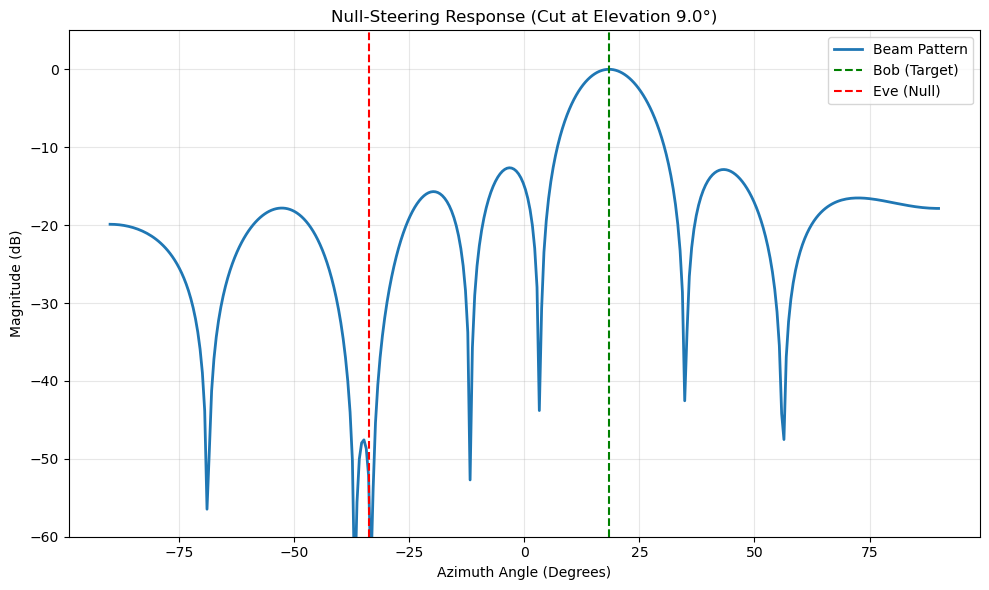

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. System Constants ---
fc = 28e9               # Carrier Frequency (Hz)
c = 3e8                 # Speed of light
wavelength = c / fc
k = 2 * np.pi / wavelength

# Array configuration (8x8 UPA)
Ny = 8
Nz = 8
N_total = Ny * Nz
d = wavelength / 2      # Half-wavelength spacing

# --- 2. Coordinate Setup ---
# Positions (x, y, z) from PDF
pos_alice = np.array([0, 0, 0])
pos_bob   = np.array([30, 10, 5])
pos_eve   = np.array([30, -20, 5])

def cartesian_to_angular(pos):
    """
    Converts (x, y, z) to Azimuth (theta) and Elevation (phi)
    based on the PDF's definitions.
    """
    x, y, z = pos
    # Azimuth (theta): Horizontal angle from x-axis
    theta = np.arctan2(y, x)

    # Elevation (phi): Vertical angle from x-y plane
    # Hypotenuse on xy plane
    r_xy = np.sqrt(x**2 + y**2)
    phi = np.arctan2(z, r_xy)

    return theta, phi

# Get angles for Bob and Eve
theta_b, phi_b = cartesian_to_angular(pos_bob)
theta_e, phi_e = cartesian_to_angular(pos_eve)

print(f"--- Geometry Check ---")
print(f"Bob Angles: Theta = {np.degrees(theta_b):.2f}°, Phi = {np.degrees(phi_b):.2f}°")
print(f"Eve Angles: Theta = {np.degrees(theta_e):.2f}°, Phi = {np.degrees(phi_e):.2f}°")

# --- 3. Steering Vector Generation ---
def get_steering_vector(theta, phi):
    """
    Generates 64x1 steering vector based on PDF Eq (2) and (3).
    a(theta, phi) = a_z(phi) (kronecker) a_y(theta, phi)
    """
    # y-dimension steering vector (Equation 2 in PDF)
    # indices n = 0 to Ny-1
    n = np.arange(Ny)
    # PDF Eq 2: exponent is -j * pi * n * sin(theta) * cos(phi)
    # Note: Using pi because d/lambda = 0.5, so k*d = pi
    psi_y = np.pi * n * np.sin(theta) * np.cos(phi)
    a_y = np.exp(-1j * psi_y)

    # z-dimension steering vector (Equation 3 in PDF)
    # indices m = 0 to Nz-1
    m = np.arange(Nz)
    # PDF Eq 3: exponent is -j * pi * m * sin(phi)
    psi_z = np.pi * m * np.sin(phi)
    a_z = np.exp(-1j * psi_z)

    # Kronecker product
    # We transpose to ensure they are column vectors effectively before kron
    # numpy kron flattens the result, so we reshape to (64, 1)
    a_total = np.kron(a_z, a_y).reshape(-1, 1)
    return a_total

# Generate Channel Vectors (Line of Sight)
h_bob = get_steering_vector(theta_b, phi_b)
h_eve = get_steering_vector(theta_e, phi_e)

# --- 4. Zero-Forcing Beamformer Calculation ---
# Formula: w = (I - P_eve) * h_bob
# P_eve = (h_eve * h_eve^H) / ||h_eve||^2

# 1. Calculate Norm squared of Eve
norm_eve_sq = np.real(np.vdot(h_eve, h_eve)) # Should be 64

# 2. Construct Projection Matrix
P_eve = (h_eve @ h_eve.conj().T) / norm_eve_sq
Identity = np.eye(N_total)
Projector = Identity - P_eve

# 3. Project Bob's channel onto the null space of Eve
w_unscaled = Projector @ h_bob

# 4. Normalize to ensure Unity Gain at Bob (|w^H h_bob| = 1)
current_gain = np.vdot(w_unscaled, h_bob) # This is complex scalar
scale_factor = 1.0 / np.conj(current_gain)
# Note: We divide by conj(gain) so that w^H * h = (1/gain)*gain = 1?
# Actually strictly: w_final = w_unscaled / (w_unscaled^H h_bob)
scale_factor = 1.0 / np.vdot(w_unscaled, h_bob)

w_final = w_unscaled * scale_factor

# --- 5. Proof & Validation ---

# Verification 1: Check Gains
gain_bob = np.abs(np.vdot(w_final, h_bob))
gain_eve = np.abs(np.vdot(w_final, h_eve))

print(f"\n--- Validation Results ---")
print(f"Power at Bob (Target 1.0): {gain_bob:.6f}")
print(f"Power at Eve (Target 0.0): {gain_eve:.6e} (effectively zero)")

# Verification 2: Check Antenna 0 Weight
w_0 = w_final[0, 0]
print(f"\n--- Manual Calculation Check ---")
print(f"Your manual calc for w_0: 0.0140 + 0.0005j")
print(f"Python sim calc for w_0:  {w_0.real:.4f} + {w_0.imag:.4f}j")

# --- 6. Visualization (The "Proof") ---

# Generate Azimuth Cut at Bob's elevation
azimuths = np.linspace(-90, 90, 360) # degrees
gains_db = []

# Using Bob's elevation for the cut (Eve is slightly different, but close)
phi_cut = phi_b

for az in azimuths:
    az_rad = np.radians(az)
    # Create steering vector for this direction
    a_scan = get_steering_vector(az_rad, phi_cut)

    # Calculate array factor (beam response)
    # Response = |w^H * a|
    resp = np.abs(np.vdot(w_final, a_scan))
    gains_db.append(20 * np.log10(resp + 1e-9)) # +1e-9 to avoid log(0)

plt.figure(figsize=(10, 6))
plt.plot(azimuths, gains_db, label='Beam Pattern', linewidth=2)

# Mark Bob and Eve locations
plt.axvline(np.degrees(theta_b), color='g', linestyle='--', label='Bob (Target)')
# Note: Eve is at a slightly different elevation, but we project her Azimuth here
plt.axvline(np.degrees(theta_e), color='r', linestyle='--', label='Eve (Null)')

plt.title(f'Null-Steering Response (Cut at Elevation {np.degrees(phi_b):.1f}°)')
plt.xlabel('Azimuth Angle (Degrees)')
plt.ylabel('Magnitude (dB)')
plt.ylim(-60, 5)
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

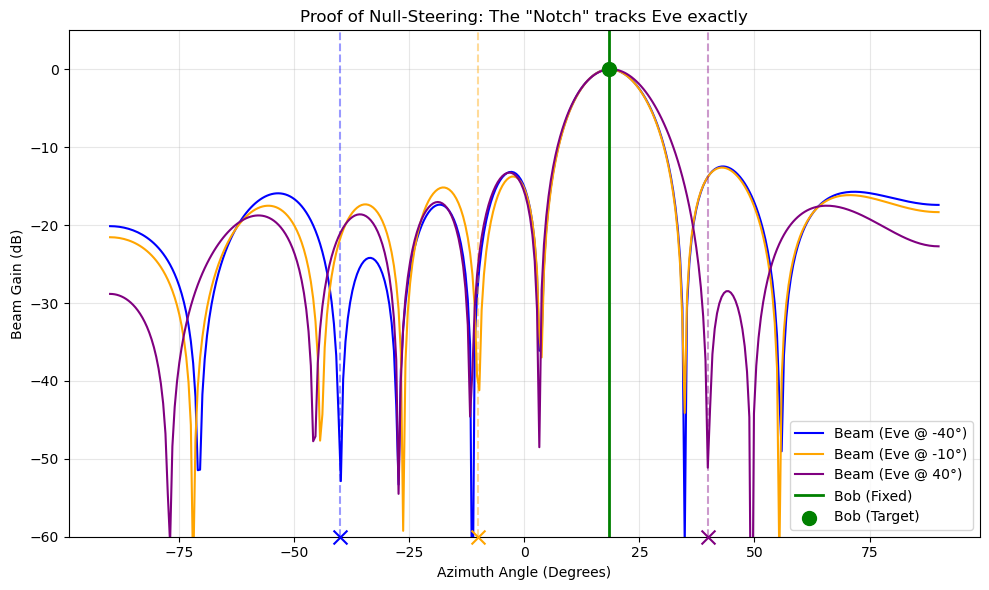

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. System Setup (Exact Formulas) ---
Ny, Nz = 8, 8
d_lam = 0.5

# Bob's Fixed Position
theta_bob_deg = 18.43
phi_bob_deg = 9.46

def get_steering_vector(theta_deg, phi_deg):
    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)
    n = np.arange(Ny)
    psi_y = 2 * np.pi * d_lam * n * np.sin(theta) * np.cos(phi)
    a_y = np.exp(-1j * psi_y)
    m = np.arange(Nz)
    psi_z = 2 * np.pi * d_lam * m * np.sin(phi)
    a_z = np.exp(-1j * psi_z)
    return np.kron(a_z, a_y).reshape(-1, 1)

h_bob = get_steering_vector(theta_bob_deg, phi_bob_deg)

# --- 2. Simulation Loop ---
capture_angles = [-40, -10, 40] # Three different "Eve" positions to test
captured_patterns = {}

for ang in capture_angles:
    # Generate Eve's Channel
    h_eve = get_steering_vector(ang, phi_bob_deg)

    # Calculate Zero-Forcing Weights
    norm_eve_sq = np.real(np.vdot(h_eve, h_eve))
    P_eve = (h_eve @ h_eve.conj().T) / norm_eve_sq
    w_unscaled = (np.eye(Ny*Nz) - P_eve) @ h_bob

    # Normalise
    gain_temp = np.vdot(w_unscaled, h_bob)
    w = w_unscaled * (1.0 / np.conj(gain_temp))

    # Scan the beam pattern
    scan_ax = np.linspace(-90, 90, 360)
    pattern = []
    for s in scan_ax:
        a_scan = get_steering_vector(s, phi_bob_deg)
        resp = np.abs(np.vdot(w, a_scan))**2
        pattern.append(10 * np.log10(resp + 1e-9))
    captured_patterns[ang] = (scan_ax, pattern)

# --- 3. Visualization ---
plt.figure(figsize=(10, 6))

colors = ['blue', 'orange', 'purple']

for i, ang in enumerate(capture_angles):
    x_data, y_data = captured_patterns[ang]
    color = colors[i]

    # Plot the beam pattern
    plt.plot(x_data, y_data, color=color, linewidth=1.5, label=f'Beam (Eve @ {ang}°)')

    # 1. The Dotted Line (Visual Guide for Angle)
    plt.axvline(ang, color=color, linestyle='--', alpha=0.4)

    # 2. The "x" Marker (Proof of Null Depth)
    # We place it at -60dB to show "it hits rock bottom here"
    plt.scatter([ang], [-60], marker='x', s=100, color=color, zorder=10, clip_on=False)

# Mark Bob
plt.axvline(theta_bob_deg, color='green', linestyle='-', linewidth=2, label='Bob (Fixed)')
plt.scatter([theta_bob_deg], [0], marker='o', s=100, color='green', zorder=10, label='Bob (Target)')

plt.title('Proof of Null-Steering: The "Notch" tracks Eve exactly')
plt.xlabel('Azimuth Angle (Degrees)')
plt.ylabel('Beam Gain (dB)')
plt.ylim(-60, 5)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()